In [ ]:
import scipy as sp
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import matplotlib.pyplot as plt

求解如下对流扩散方程
$$
L u=-\varepsilon \Delta u+a u_{x}+b u_{y}=f^{\Omega}(x, y) \quad\left(\Omega=(0,1)^{2}\right)
$$

一阶迎风格式

In [ ]:
def upwind_stencil(epsilon, a, b, h):
    """
    Creates the first-order upwind stencil
    """
    stencil = np.zeros((3, 3))
    stencil[1, 1] = h*(abs(a) + abs(b)) +4*epsilon
    stencil[0, 1] = 1/2*h*(b-abs(b)) - epsilon
    stencil[1, 0] = -1/2*h*(a+abs(a)) - epsilon
    stencil[1, 2] = 1/2*h*(a-abs(a)) - epsilon
    stencil[2, 1] = -1/2*h*(b+abs(b)) - epsilon
    # stencil/=(h**2)
    return stencil

二阶中心差分离散格式，只有当Peclet条件满足格式才稳定
$$
P e:=\frac{h}{\varepsilon} \max (|a|,|b|) \leq 2
$$

In [ ]:
def central_stencil(epsilon, a, b, h):
    """
    Creates the second-order upwind stencil
    """
    stencil = np.zeros((3, 3))
    stencil[1, 1] = 4*epsilon
    stencil[0, 1] = b*h/2 - epsilon
    stencil[1, 0] = -a*h/2 - epsilon
    stencil[1, 2] = a*h/2 - epsilon
    stencil[2, 1] = -b*h/2 - epsilon
    # stencil/=(h**2)
    return stencil

stencil to matrix

In [ ]:
def stencil_grid(S, grid):
    N_v = np.prod(grid)  # number of vertices in the mesh
    N_s = (S != 0).sum() # number of nonzero stencil entries

    # diagonal offsets
    diags = np.zeros(N_s, dtype=int)

    # compute index offset of each dof within the stencil
    strides = np.cumprod([1] + list(reversed(grid)))[:-1]
    indices = tuple(i.copy() for i in S.nonzero())
    for i, s in zip(indices, S.shape):
        i -= s // 2

    for stride, coords in zip(strides, reversed(indices)):
        diags += stride * coords

    data = S[S != 0].repeat(N_v).reshape(N_s, N_v)

    indices = np.vstack(indices).T

    # zero boundary connections
    for index, diag in zip(indices, data):
        diag = diag.reshape(grid)
        for n, i in enumerate(index):
            if i > 0:
                s = [slice(None)] * len(grid)
                s[n] = slice(0, i)
                s = tuple(s)
                diag[s] = 0
            elif i < 0:
                s = [slice(None)]*len(grid)
                s[n] = slice(i, None)
                s = tuple(s)
                diag[s] = 0

    # remove diagonals that lie outside matrix
    mask = abs(diags) < N_v
    if not mask.all():
        diags = diags[mask]
        data = data[mask]

    # sum duplicate diagonals
    if len(np.unique(diags)) != len(diags):
        new_diags = np.unique(diags)
        new_data = np.zeros((len(new_diags), data.shape[1]),
                            dtype=data.dtype)

        for dia, dat in zip(diags, data):
            n = np.searchsorted(new_diags, dia)
            new_data[n, :] += dat

        diags = new_diags
        data = new_data

    return sparse.dia_matrix((data, diags), shape=(N_v, N_v)).tocsr()

In [ ]:
def relaxJ(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    Dinv = sparse.spdiags(1./A.diagonal(), [0], n, n)
    omega = 4 / 5
    for i in range(nu):
        unew += omega * Dinv * (f - A * unew)
    return unew

def relaxGS(A, u, f, nu):
    n = A.shape[0]
    unew = u.copy()
    D = sparse.spdiags(A.diagonal(), [0], A.shape[0], A.shape[1], format='csr')
    E = -sparse.tril(A, -1)
    
    for i in range(nu):
        unew += sla.spsolve(D-E, f - A * unew)

    return unew

In [ ]:
def hnorm(r):
    """define ||r||_h = h ||r||_2"""
    n = len(r)
    h = 1.0 / (n+1)
    hrnorm = h * np.linalg.norm(r)
    return hrnorm

In [ ]:
def interpolation1d(nc, nf):
    d = np.repeat([[1, 2, 1]], nc, axis=0).T
    I = np.zeros((3,nc), dtype=int)
    for i in range(nc):
        I[:,i] = [2*i, 2*i+1, 2*i+2]
    J = np.repeat([np.arange(nc)], 3, axis=0)
    P = sparse.coo_matrix(
        (d.ravel(), (I.ravel(), J.ravel()))
        ).tocsr()
    return 0.5 * P

In [ ]:
relax = relaxGS
def twogrid(A, P, A1, u0, f0, nu):
    u0 = relax(A, u0, f0, nu)
    f1 = P.T * (f0 - A * u0)

    u1 = sla.spsolve(A1, f1)

    u0 = u0 + P * u1
    u0 = relax(A, u0, f0, nu)
    return u0

### 生成系统

In [ ]:
k = 6
n = 2**k - 1
nc = 2**(k-1) - 1
h = 1/(n+1)
epsilon, a, b = 1e-3, 1, 1

print(n)
# upwindA = upwind_stencil(epsilon, a, b, h)
# A = stencil_grid(upwindA, (n, n))

centralA = central_stencil(epsilon, a, b, h)
A = stencil_grid(centralA, (n, n))

f = np.ones((n,n))*h**2   #* h^2乘到这里
f[-1,:-1] -= centralA[2,1] 
f[:-1, -1] -= centralA[1,2] 
f[-1,-1] = f[-1,-1] - centralA[2,1] - centralA[1,2]
f = f.ravel()
# plt.pcolor(f, cmap='RdBu')
# plt.colorbar()


In [ ]:
centralA

### solve Au = f

In [ ]:
# x = np.ones(n**2)      # true solution
# b = A@x                # right-hand side
relax = relaxJ
u = np.zeros_like(f)   # initial guess
res = 1
k = 1
ress = [res]
while res > 1e-6 and k<20000:
    u = relax(A, u, f, 1)
    res = np.linalg.norm(f - A @ u)/np.linalg.norm(f)
    ress.append(res)
    k = k + 1
res = np.array(ress)
plt.semilogy(res)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('residual')

### 测试磨光

In [ ]:
u = np.random.rand(n*n)

plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

relax = relaxJ
u = relax(A, u, f, 5)
plt.figure()
plt.pcolormesh(u.reshape(n,n))
plt.colorbar()

## Cheby-semi

In [ ]:
def Chebyshev_smoother(A, b, x0, taus, K):
    for k in range(K):
        for i in range(len(taus)):
            r = b - A@x0
            x0 = x0 + taus[i] * r
    return x0


In [ ]:
from scipy import linalg
eA = linalg.eigvals(A.toarray()).real
m = 10
roots = [np.cos((np.pi*(2*i+1)) / (2*m)) for i in range(m)]
miu = min(eA)
L = max(eA)
taus = [2 / (L + miu - (miu - L) * r) for r in roots]

In [ ]:
u = np.zeros_like(f)   # initial guess
res = 1
k = 1
ress = [res]
while res > 1e-6 and k<20000:
    u = Chebyshev_smoother(A, f, u, taus, 1)
    res = np.linalg.norm(f - A @ u)/np.linalg.norm(f)
    ress.append(res)
    k = k + 1
res = np.array(ress)
plt.semilogy(res)
plt.grid()
plt.xlabel('iteration')
plt.ylabel('residual')

In [42]:
import torch

In [82]:
def ComputeSmootherFactor(KernelA, N, tol, taus):
    device = KernelA.device
    h = 1/(N+1)
    p1 = range(-N//2, N//2)
    p2 = range(-N//2, N//2)
    # p1 = np.fft.fftshift(p2)
    # p2 = np.fft.fftshift(p2)
    P1, P2 = np.meshgrid(p1, p2)
    P1 = torch.from_numpy(P1)
    P2 = torch.from_numpy(P2)
    P1, P2 = P1.to(device), P2.to(device)
    theta1 = 2*np.pi*P1*h
    theta2 = 2*np.pi*P2*h
    Y = torch.ones([KernelA.shape[0], 1, N, N], device=device)
    for i in range(KernelA.shape[0]):
        k1, k2, k3, k4, k5 = KernelA[i, 0, 0, 1], KernelA[i, 0, 1, 0], KernelA[i, 0, 1, 1], KernelA[i, 0, 1, 2], KernelA[i, 0, 2, 1]
        y = 1
        for j in range(len(taus)):
            y *= 1-taus[j]*(k1*torch.exp(-1j*theta2)+k2*torch.exp(-1j*theta1)+k3+k4*torch.exp(1j*theta1)+k5*torch.exp(1j*theta2))
            # print(y)
            plt.pcolor(P1, P2, np.abs(y.numpy()), cmap='jet')
            plt.colorbar()
            plt.savefig('/home/kaijiang/cuichen/FNSsummer/0804/data/m_'+str(len(taus))+'_'+str(j+1)+'.jpg', dpi=300)
            plt.close()
        Y[i, 0, :, :] = y
        # break
    idx = torch.where(torch.abs(Y) < tol)
    return idx

In [96]:
def CreateKernelA(paras, data_num=1):
    m = paras.shape[0]
    KernelA = torch.zeros([m*data_num, 1, 3, 3], dtype=torch.float64)
    for i in range(m):
        epsilon, a, b, h = paras[i]
        stencil = torch.zeros(3, 3)
        stencil[1, 1] = 4*epsilon
        stencil[0, 1] = b*h/2 - epsilon
        stencil[1, 0] = -a*h/2 - epsilon
        stencil[1, 2] = a*h/2 - epsilon
        stencil[2, 1] = -b*h/2 - epsilon
        # stencil = stencil/(h**2)
        for j in range(data_num):
            KernelA[i*data_num+j, 0] = stencil
    return KernelA

In [97]:
N = 63
h = 1/(N+1)
epsilons_train = torch.tensor([1e-3, 1e-4, 1e-5, 1e-6])
print(epsilons_train)

etas_train = torch.zeros(4, 4)
etas_train[:, 0] = epsilons_train
etas_train[:, 1] = 1
etas_train[:, 2] = 1
etas_train[:, 3] = h
KernelA = CreateKernelA(etas_train)

A = stencil_grid(KernelA[0,0].numpy(), (N, N))
from scipy import linalg
eA = linalg.eigvals(A.toarray()).real


tensor([1.0000e-03, 1.0000e-04, 1.0000e-05, 1.0000e-06])


In [99]:
m = 1
roots = [np.cos((np.pi*(2*i+1)) / (2*m)) for i in range(m)]
# miu = min(eA)
L = max(eA)
miu = L / 5
# taus = [2 / (L + miu - (miu - L) * r) for r in roots]
taus = [1/A[1,1]*4/5]  #* Jacobi
print(taus)
idx = ComputeSmootherFactor(KernelA, N, 0.5, taus)

[199.9999905005102]


/home/kaijiang/miniconda3/envs/pde/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


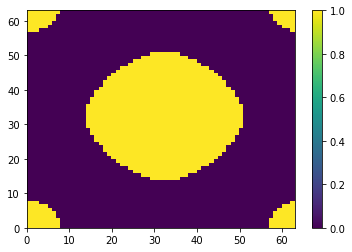

In [100]:
x = np.ones((4,1,N,N))
x[idx] = 0
idx1 = np.where(x[0,0,:,:] == 0)
idx2 = np.where(x[1,0,:,:] == 0)

y = np.ones((N,N))
y[idx1[-1], idx1[-2]] = 0
plt.pcolor(y)
plt.colorbar()

### GMG

In [ ]:
# P1d = interpolation1d(nc, n)
# P = sparse.kron(P1d, P1d).tocsr()

# u = np.zeros_like(f)

# A1 = P.T * A * P
# res = [1]
# for i in range(30):
#     u = twogrid(A, P, A1, u, f, 3)
#     res1 = np.linalg.norm(f - A @ u)/np.linalg.norm(f)
#     res.append(res1)

# res = np.array(res)
# print(res)
# print(res[1:] / res[:-1])
# plt.semilogy(res)
# plt.grid()
# plt.xlabel('iteration')
# plt.ylabel('residual')

In [101]:
import torch
torch.pow(0.1, torch.rand(20)*3)*1e-2

tensor([1.9717e-04, 2.2193e-04, 4.0356e-05, 3.3459e-05, 1.9471e-05, 2.7565e-05,
        3.5881e-04, 4.5361e-05, 1.3497e-05, 1.1138e-03, 1.1617e-04, 1.2559e-03,
        3.2491e-05, 2.0872e-03, 1.8504e-05, 4.6658e-04, 2.5305e-04, 1.3093e-04,
        3.1015e-05, 1.3941e-03])

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import torch

In [12]:
p1[-1]

31

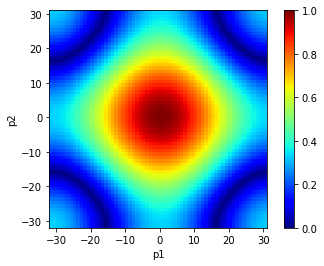

In [25]:
N = 64
h = 1/N
omega = 2/3
p1 = range(-N//2, N//2)
p2 = range(-N//2, N//2)
P1, P2 = np.meshgrid(p1, p2)
P1 = torch.from_numpy(P1)
P2 = torch.from_numpy(P2)
theta1 = 2*np.pi*P1*h
theta2 = 2*np.pi*P2*h
Y = 1-omega +omega/2*(np.cos(theta1)+np.cos(theta2))
plt.pcolor(P1, P2, np.abs(Y.numpy()), cmap='jet')
plt.colorbar()
plt.xlabel('p1')
plt.ylabel('p2')
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('/home/kaijiang/cuichen/FNSsummer/0807/data/poisson.png', dpi=300)

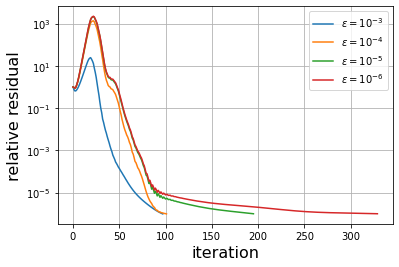

In [6]:
import numpy as np
from matplotlib import pyplot as plt
res3 = np.load("/home/kaijiang/cuichen/FNSsummer/0817/expriments/mL_3KS_5/prediction/ress_FNS_3.npy")
res4 = np.load("/home/kaijiang/cuichen/FNSsummer/0817/expriments/mL_3KS_5/prediction/ress_FNS_4.npy")
res5 = np.load("/home/kaijiang/cuichen/FNSsummer/0817/expriments/mL_3KS_5/prediction/ress_FNS_5.npy")
res6 = np.load("/home/kaijiang/cuichen/FNSsummer/0817/expriments/mL_3KS_5/prediction/ress_FNS_6.npy")
plt.semilogy(res3, label=r'$\varepsilon=10^{-3}$')
plt.semilogy(res4, label=r'$\varepsilon=10^{-4}$')
plt.semilogy(res5, label=r'$\varepsilon=10^{-5}$')
plt.semilogy(res6, label=r'$\varepsilon=10^{-6}$')
plt.grid()
plt.legend()
plt.xlabel('iteration', fontsize=16)
plt.ylabel('relative residual', fontsize=16)
plt.savefig('/home/kaijiang/cuichen/FNSsummer/0817/expriments/mL_3KS_5/prediction/ad_residual.jpg', dpi=300)
